## 1. 분석 목표

본 분석의 목표는 **Resort Hotel**의 예약 데이터를 사용하여 고객의 특성을 깊이 있게 이해하고, 비즈니스 인사이트를 도출하는 데 있다. 구체적인 목표는 다음과 같다.

1.  **기술적 고객 세분화 (Customer Segmentation):** 고객의 예약 행동 및 인구통계학적 특성을 기반으로 군집화를 진행하여, 서로 다른 특성을 가진 고객 그룹(페르소나)을 정의한다. 이는 타겟 마케팅 전략 수립 및 맞춤형 서비스 제공의 기반이 된다.
2.  **예약 취소 예측 모델링:** 고객의 예약 정보와 행동 패턴을 분석하여 예약 취소 가능성을 예측하는 분류 모델을 구축한다. 이를 통해 잠재적 취소 고객을 사전에 식별하고, 취소 방지를 위한 선제적 대응(프로모션 제공 등)을 가능하게 한다.

**추가 분석 및 시각화**: `plotly` 라이브러리를 활용하여 클러스터별 특징을 더욱 풍부하게 시각화하여 비즈니스 인사이트 도출을 강화합니다.

## 2. 분석 프로세스 개요

분석은 다음과 같은 6단계의 구조화된 프로세스로 진행된다.

1.  **EDA (탐색적 데이터 분석):** 데이터의 구조, 분포, 변수 간 관계를 파악하여 데이터에 대한 근본적인 이해를 높인다.
2.  **데이터 전처리:** 분석 목적에 맞게 데이터를 정제하고, 파생 변수를 생성하며, 모델링에 적합한 형태로 가공한다.
3.  **가설 검정:** 데이터 기반의 통계적 가설을 설정하고 검정하여, 유의미한 비즈니스 인사이트를 도출한다.
4.  **고객 클러스터링:** 비지도 학습 기법을 사용하여 고객을 유사한 특성을 가진 그룹으로 분류하고, 각 그룹의 페르소나를 정의한다.
5.  **시각화:** 분석 과정에서 발견한 주요 인사이트와 클러스터링, 모델링 결과를 효과적으로 전달하기 위한 시각 자료를 생성한다.
6.  **모델링 (예약 취소 예측):** 지도 학습 알고리즘을 사용하여 예약 취소 여부를 예측하는 모델을 구축하고 성능을 평가한다.

## 3. 세부 분석 계획

### 3.1. EDA (탐색적 데이터 분석)

데이터의 잠재적 패턴과 이상 징후를 초기에 발견하기 위한 단계이다.

#### 3.1.0. 모듈 및 폰트 설정

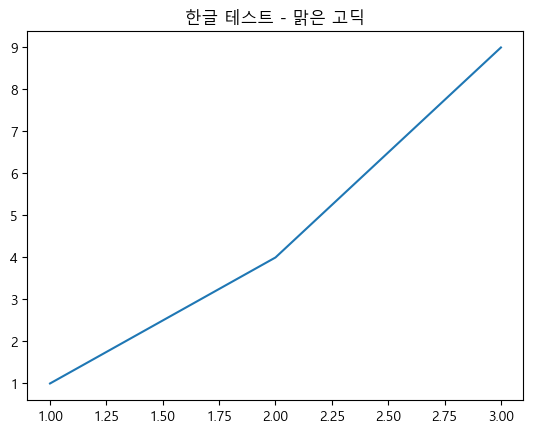

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기본)
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

plt.plot([1,2,3],[1,4,9])
plt.title("한글 테스트 - 맑은 고딕")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#### 3.1.1. 데이터 로드 및 기본 정보 확인

-   **수행 내용:** `pandas` 라이브러리를 사용하여 `hotel_booking.csv` 파일을 DataFrame으로 로드한다. `.info()`, `.head()`, `.describe(include='all')` 함수를 통해 데이터의 전체적인 구조, 컬럼별 데이터 타입, 결측치 유무, 기초 통계량을 확인한다.
-   **선택 근거:** 데이터 분석의 가장 첫 단계로, 데이터의 무결성(integrity)과 기본적인 특성을 파악하여 이후의 분석 계획을 구체화하는 데 필수적이다.

In [ ]:
import pandas as pd

# 같은 경로에 있는 CSV 파일 로드
file_path = 'hotel_booking.csv'
df = pd.read_csv(file_path)

df.head()

### 3.2. 데이터 전처리 (Data Preprocessing)

분석의 정확성과 모델의 성능을 극대화하기 위해 데이터를 정제하고 구조화하는 단계이다.

In [ ]:

# CSV 파일 로드
df = pd.read_csv(file_path)

df = df.drop(columns=["hotel"])

df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + " " +
    df["arrival_date_month"].astype(str) + " " +
    df["arrival_date_day_of_month"].astype(str),
    format="%Y %B %d"
)

df["booking_date"] = df["arrival_date"] - pd.to_timedelta(df["lead_time"], unit="D")

# NaN 값을 0으로 채운 후 정수형으로 변환
df["adults"] = df["adults"].fillna(0).astype(int)
df["children"] = df["children"].fillna(0).astype(int)
df["babies"] = df["babies"].fillna(0).astype(int)


df['total_guests'] = df['adults'] + df['children'] + df['babies']

df = df.drop(columns=['name', 'email','phone-number', 'credit_card'])

df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

df['is_child'] = (df['children'] > 0) | (df['babies'] > 0)

#### 3.2.3. 결측치 및 무효 데이터 처리

-   **수행 내용:**
    1.  `total_guests`가 0인 행을 제거한다. (예약에 사람이 없는 경우는 데이터 오류)
    2.  `stays_in_weekend_nights`와 `stays_in_week_nights`의 합이 0인 행을 제거한다. (최소 1박 이상 숙박해야 함)
    3.  `children`, `country`, `agent` 컬럼의 결측치(NaN)를 처리한다.
        -   `children`: 0으로 대체한다. (자녀가 없으면 비워두는 경우가 많음)
        -   `country`: 최빈값(mode)으로 대체한다. (국적 정보는 중요 변수이므로 행 삭제보다 대체가 유리)
        -   `agent`: 0으로 대체한다. (결측치는 에이전트를 통하지 않은 직접 예약을 의미할 가능성이 높음)
-   **선택 근거:** 논리적으로 유효하지 않은 데이터를 제거하여 분석 결과의 신뢰도를 높인다. 결측치는 각 변수의 특성을 고려한 합리적인 방식으로 처리하여 데이터 손실을 최소화하고, 분석의 편향을 줄인다.

In [ ]:
df[df['total_guests'] <= 0].shape

(180, 36)

In [ ]:
df[df['total_nights'] <= 0].shape

(715, 36)

In [ ]:
# total_guests가 0인 행 제거
df_cleaned = df[df['total_guests'] > 0]
df_cleaned = df_cleaned[df_cleaned['total_nights'] > 0]

#### 3.2.4. 이상치 처리 (현재 미적용, 추후 적용 계획)

-   **수행 내용:** 현재 단계에서는 이상치를 처리하지 않으나, 향후 모델 성능 저하의 원인으로 판단될 경우 적용할 수 있도록 계획을 수립한다.
-   **선택 근거:** 이상치는 실제 데이터의 중요한 특성일 수 있으므로, 무조건적인 제거는 정보 손실을 야기할 수 있다. 따라서 해당 분석에서는 그대로 두고 진행한다.

In [ ]:
# 이상치 처리 안 함

### 3.4. 고객 클러스터링 (Customer Clustering)

고객을 행동 및 특성에 따라 그룹화하여 페르소나를 도출한다.

#### 3.4.1. 클러스터링용 데이터 준비

-   **수행 내용:** 클러스터링에 사용할 변수(`country`, `market_segment`, `distribution_channel`, `room_match_flag`, `customer_group`, `is_repeated_guest`)를 선택하여 새로운 데이터프레임을 생성한다.
-   **선택 근거 및 누수 방지:**
    -   요구사항에 명시된 변수들을 사용하여 고객의 예약 채널, 시장, 구성, 충성도, 서비스 만족도 등 다각적인 특성을 반영한다.
    -   **[중요] 데이터 누수(Data Leakage) 방지:** 클러스터링은 기술적 세분화가 목적이므로 사후에 확정되는 `room_match_flag`를 사용하는 것이 허용된다. 하지만, 이 변수를 **예약 취소 예측 '지도학습' 모델**의 피처로 사용할 경우, 미래의 정보(체크인 시점에 확정되는 정보)를 사용하여 과거(예약 시점)의 일을 예측하는 **데이터 누수**가 발생하므로 **절대 사용해서는 안 된다.** 이 점을 명확히 인지하고 모델링 단계에서는 해당 변수를 제외한다.

In [ ]:
df_cleaned.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'booking_date', 'total_guests', 'total_nights', 'is_child'],
      dtype='object')

In [ ]:
# 클러스터링에 사용할 변수 선택
clustering_features = ['lead_time','market_segment', 'distribution_channel', 'total_guests', 'is_child',
       'customer_type', 'total_of_special_requests','total_nights']
df_clustering = df_cleaned[clustering_features].copy()

#### 3.4.2. 범주형 변수 인코딩 및 스케일링

-   **수행 내용:**
    1.  `pd.get_dummies()` 함수를 사용하여 모든 범주형 변수를 원-핫 인코딩(One-Hot Encoding)으로 변환한다. `country`와 같이 범주가 매우 많은 변수는 상위 N개만 사용하고 나머지는 'Other'로 묶는 방식을 고려한다.
    2.  `StandardScaler`를 사용하여 모든 변수를 표준 정규 분포(평균 0, 표준편차 1)를 따르도록 스케일링한다.
-   **선택 근거:** 대부분의 군집 알고리즘(특히 K-Means)은 유클리드 거리를 기반으로 하므로, 모든 변수가 동일한 스케일을 갖도록 정규화해야 한다. 그렇지 않으면 특정 변수의 큰 값 범위가 군집 결과에 과도한 영향을 미치게 된다.

In [ ]:
from sklearn.preprocessing import StandardScaler

'''# Country 변수 처리: 상위 10개 국가만 남기고 나머지는 'Other'로 묶기
top_countries = df_clustering['country'].value_counts().nlargest(10).index.tolist()
df_clustering['country_processed'] = df_clustering['country'].apply(lambda x: x if x in top_countries else 'Other')'''

# 범주형 변수 원-핫 인코딩 (처리된 country 변수 포함)
categorical_features = ['market_segment', 'distribution_channel','is_child','customer_type']
df_clustering_encoded = pd.get_dummies(df_clustering, columns=categorical_features, drop_first=True)

# 스케일링 대상 변수 선택 (room_match_flag와 is_repeated_guest는 이미 0/1 값이므로 스케일링 제외)
features_to_scale = df_clustering_encoded.columns.difference(['lead_time', 'total_guests', 'total_of_special_requests','total_nights'])

# StandardScaler를 사용하여 스케일링
scaler = StandardScaler()
df_clustering_scaled = df_clustering_encoded.copy()
df_clustering_scaled[features_to_scale] = scaler.fit_transform(df_clustering_encoded[features_to_scale])

#### 3.4.3. 클러스터링 알고리즘 적용 및 비교

-   **수행 내용:** 단일 알고리즘의 한계를 극복하고 데이터 구조에 가장 적합한 모델을 찾기 위해 여러 알고리즘을 비교/분석한다.
    1.  **K-Means:**
        -   **적용:** 엘보우 메소드(Elbow Method)와 실루엣 점수(Silhouette Score)를 사용하여 최적의 클러스터 개수(K)를 결정하고 모델을 학습시킨다.
        -   **해석:** 각 클러스터의 중심(centroid) 값을 분석하여 그룹의 특성을 파악한다. 계산이 빠르고 해석이 용이하지만, 군집이 구형(spherical)이라고 가정하는 한계가 있다.
    2.  **계층적 군집화 (Hierarchical Clustering):**
        -   **적용:** 덴드로그램(Dendrogram)을 시각화하여 적절한 클러스터 개수를 결정하고, AgglomerativeClustering을 적용한다.
        -   **해석:** 클러스터 간의 위계 관계를 파악할 수 있다. 데이터가 적을 때 유용하지만, 대용량 데이터에는 계산 비용이 높다.
    3.  **DBSCAN:**
        -   **적용:** `eps`와 `min_samples` 하이퍼파라미터를 조정하며 군집을 형성한다.
        -   **해석:** 밀도 기반으로 군집을 형성하므로 K-Means로 찾기 어려운 복잡한 형태의 군집을 발견할 수 있으며, 노이즈(어떤 군집에도 속하지 않는 데이터)를 식별할 수 있다.
-   **선택 근거:** 각 알고리즘은 서로 다른 가정과 장단점을 가지므로, 여러 모델을 비교하여 데이터의 숨겨진 구조를 가장 잘 표현하는 결과를 선택하는 것이 강건한(robust) 분석 방법이다.

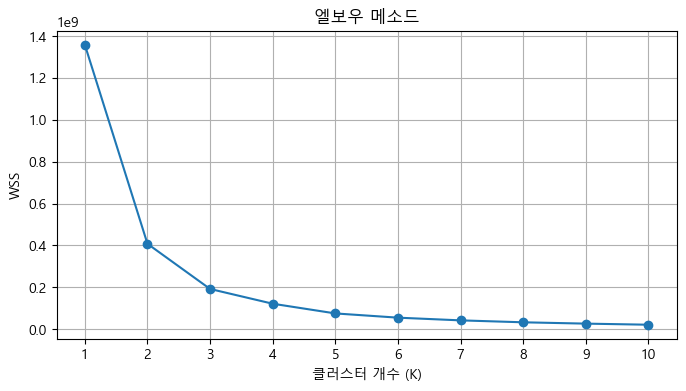

클러스터 개수 2의 실루엣 점수: 0.6580257074895086
클러스터 개수 3의 실루엣 점수: 0.6235718282294159
클러스터 개수 4의 실루엣 점수: 0.5853569202263611
클러스터 개수 5의 실루엣 점수: 0.5896329029741436
클러스터 개수 6의 실루엣 점수: 0.5591325942263554
클러스터 개수 7의 실루엣 점수: 0.5482619628236705
클러스터 개수 8의 실루엣 점수: 0.5413796502778611
클러스터 개수 9의 실루엣 점수: 0.5430721424885695
클러스터 개수 10의 실루엣 점수: 0.5269903777551145


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# K-Means 클러스터링 (엘보우 메소드 및 실루엣 점수)

# 엘보우 메소드를 위한 WSS (Within-Cluster Sum of Square)
wss = []
for i in range(1, 11): # 클러스터 개수 1부터 10까지 시도
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_clustering_scaled)
    wss.append(kmeans.inertia_)

# 엘보우 메소드 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wss, marker='o')
plt.title('엘보우 메소드')
plt.xlabel('클러스터 개수 (K)')
plt.ylabel('WSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# 실루엣 점수를 위한 계산
silhouette_scores = []
for i in range(2, 11): # 실루엣 점수는 클러스터 개수 2부터 계산 가능
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_clustering_scaled)
    score = silhouette_score(df_clustering_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"클러스터 개수 {i}의 실루엣 점수: {score}")

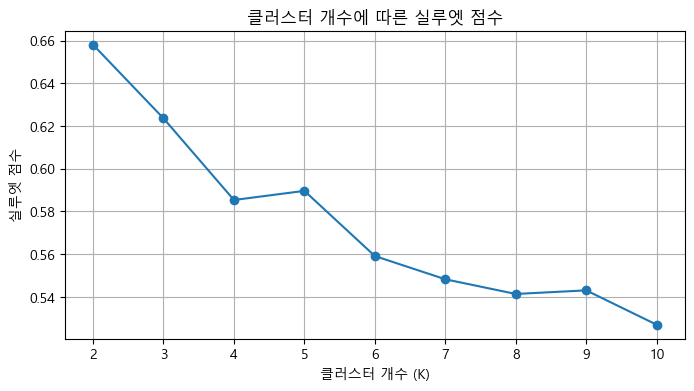

In [ ]:
# 실루엣 점수 시각화
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('클러스터 개수에 따른 실루엣 점수')
plt.xlabel('클러스터 개수 (K)')
plt.ylabel('실루엣 점수')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

#### 3.4.4. 클러스터 시각화 및 해석


In [ ]:
optimal_k = 5

# 최적의 K로 K-Means 모델 학습
# optimal_k는 이전 셀에서 결정된 값 사용
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
kmeans_final.fit(df_clustering_scaled)

# 원본 데이터프레임에 클러스터 라벨 추가
df_resort_clustered = df_cleaned.copy()
df_resort_clustered['cluster_label'] = kmeans_final.labels_

In [ ]:
df_resort_clustered.to_csv('hotel_customer_clustered.csv')

In [ ]:
df = pd.read_csv('hotel_customer_clustered.csv')
df = df.drop(columns=['Unnamed: 0'])
df.to_csv('hotel_customer_clustered.csv')

In [ ]:
# 클러스터별 특성 분석
# 수치형 변수의 평균, 범주형 변수의 최빈값 또는 비율 등을 계산
cluster_profiling = df_resort_clustered.groupby('cluster_label').agg(
    # 수치형 변수 예시 (필요에 따라 추가/변경)
    adr_mean=('adr', 'mean'),
    lead_time_mean=('lead_time', 'mean'),
    total_guests_mean=('total_guests', 'mean'),
    total_nights_mean=('total_nights', 'mean'),
    is_canceled_rate=('is_canceled', 'mean'), # 취소율

    # 범주형 변수 예시 (최빈값 또는 비율 계산, 필요에 따라 추가/변경)
    market_segment_mode=('market_segment', lambda x: x.mode()[0] if not x.mode().empty else 'N/A'),
    is_repeated_guest_ratio=('is_repeated_guest', 'mean'), # 반복 고객 비율

    # 다른 변수들에 대해서도 유사하게 분석 가능
).reset_index()

print(f"{optimal_k}개 클러스터 프로파일링 결과:")
display(cluster_profiling)

5개 클러스터 프로파일링 결과:


,cluster_label,adr_mean,lead_time_mean,total_guests_mean,total_nights_mean,is_canceled_rate,market_segment_mode,is_repeated_guest_ratio
0,0,102.183270,18.116142,1.883917,2.790937,0.231195,Online TA,0.058217
1,1,78.803145,434.400352,1.911782,2.639801,0.670574,Groups,0.001465
2,2,107.940864,175.652172,2.049239,4.311630,0.456609,Online TA,0.004362
3,3,107.451620,88.908603,2.051421,3.813614,0.416440,Online TA,0.006243
4,4,89.155852,286.860636,2.030934,3.990607,0.627095,Groups,0.017653


In [ ]:
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# df_resort_clustered DataFrame 사용

# 클러스터별 market_segment 분포 계산
df_market_segment_cluster = df_resort_clustered.groupby(['cluster_label', 'market_segment']).size().reset_index(name='count')

# 각 클러스터별 파이 차트 생성
clusters = sorted(df_market_segment_cluster['cluster_label'].unique())
num_clusters = len(clusters)

# 서브플롯 설정 (한 줄에 모든 파이 차트 표시)
rows = 1
cols = num_clusters

fig_market_segment = make_subplots(rows=rows, cols=cols, specs=[[{'type':'domain'}]*cols],
                                   subplot_titles=[f'클러스터 {c}' for c in clusters])

# 각 클러스터에 대해 파이 차트 추가
for i, cluster in enumerate(clusters):
    df_cluster = df_market_segment_cluster[df_market_segment_cluster['cluster_label'] == cluster]
    if not df_cluster.empty:
        fig_market_segment.add_trace(go.Pie(labels=df_cluster['market_segment'], values=df_cluster['count'], name=f'클러스터 {cluster}'),
                                     1, i+1) # row, col 순서 (1행 i+1열)

fig_market_segment.update_layout(title_text='클러스터별 Market Segment 분포', height=400, width=1200) # 차트 크기 조정
fig_market_segment.show()

클러스터별 특성 프로파일 (평균값):


,adr,lead_time,total_guests,stays_in_weekend_nights,stays_in_week_nights
cluster_label,,,,,
0,102.183270,18.116142,1.883917,0.756466,2.034471
1,78.803145,434.400352,1.911782,0.570340,2.069461
2,107.940864,175.652172,2.049239,1.175654,3.135975
3,107.451620,88.908603,2.051421,1.064747,2.748867
4,89.155852,286.860636,2.030934,1.018949,2.971658


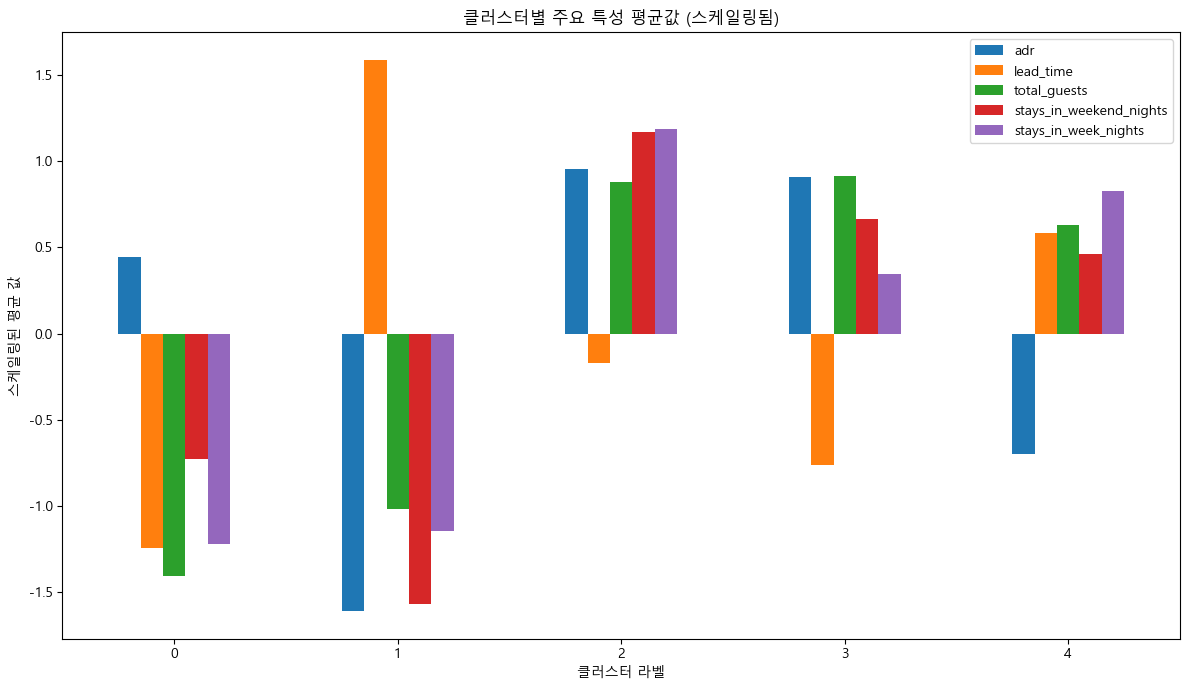

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd # pandas 임포트 추가

# df_resort_clustered DataFrame 사용 및 'cluster_label'로 그룹화
# 실제 데이터에 있는 수치형 컬럼들 사용 (예시: adr, lead_time, total_guests 등)
# cluster_profile = df.groupby("cluster")[["Income","Spent","Recency","Age"]].mean() # <-- 오류 코드

# 클러스터별 수치형 변수 평균 계산
cluster_profile_actual = df_resort_clustered.groupby("cluster_label")[['adr', 'lead_time', 'total_guests', 'stays_in_weekend_nights', 'stays_in_week_nights']].mean()


print("클러스터별 특성 프로파일 (평균값):")
display(cluster_profile_actual)

# 클러스터 프로파일 데이터 스케일링
scaler_profile = StandardScaler()
cluster_profile_scaled = scaler_profile.fit_transform(cluster_profile_actual)

# 스케일링된 데이터를 DataFrame으로 변환 (시각화를 위해)
cluster_profile_scaled_df = pd.DataFrame(cluster_profile_scaled, columns=cluster_profile_actual.columns, index=cluster_profile_actual.index)


# 클러스터 프로파일 시각화 (스케일링된 값 사용)
cluster_profile_scaled_df.plot(kind="bar", figsize=(12, 7))
plt.title("클러스터별 주요 특성 평균값 (스케일링됨)")
plt.xlabel("클러스터 라벨")
plt.ylabel("스케일링된 평균 값")
plt.xticks(rotation=0) # 클러스터 라벨이 숫자이므로 회전 불필요
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# df_resort_clustered DataFrame 사용

# 클러스터별 reserved_room_type 분포 계산
df_room_type_cluster = df_resort_clustered.groupby(['cluster_label', 'reserved_room_type']).size().reset_index(name='count')

# 각 클러스터별 파이 차트 생성
clusters = sorted(df_room_type_cluster['cluster_label'].unique())
num_clusters = len(clusters)

# 서브플롯 설정 (한 줄에 모든 파이 차트 표시)
rows = 1
cols = num_clusters

fig_room_type = make_subplots(rows=rows, cols=cols, specs=[[{'type':'domain'}]*cols],
                                   subplot_titles=[f'클러스터 {c}' for c in clusters])

# 각 클러스터에 대해 파이 차트 추가
for i, cluster in enumerate(clusters):
    df_cluster = df_room_type_cluster[df_room_type_cluster['cluster_label'] == cluster].copy() # Create a copy

    if not df_cluster.empty:
        fig_room_type.add_trace(go.Pie(labels=df_cluster['reserved_room_type'], values=df_cluster['count'], name=f'클러스터 {cluster}',
                                       hoverinfo='label+value+percent'), # Show hover info
                                1, i+1) # row, col 순서 수정

fig_room_type.update_layout(title_text='클러스터별 이용 객실 유형 분포', height=400, width=1200) # 차트 크기 조정
fig_room_type.show()

In [ ]:
from scipy import stats
import pandas as pd

# df_resort_clustered DataFrame 사용

print("클러스터별 범주형 변수 분포 차이 카이제곱 검정:")

# 클러스터 라벨과 reserved_room_type 간의 교차표 생성
contingency_table_room_type = pd.crosstab(df_resort_clustered['cluster_label'], df_resort_clustered['reserved_room_type'])

print("\nCluster 라벨과 Reserved Room Type 간의 교차표:")
display(contingency_table_room_type)

# 카이제곱 검정 수행
chi2_room_type, p_room_type, dof_room_type, expected_room_type = stats.chi2_contingency(contingency_table_room_type)

print(f"\nCluster 라벨과 Reserved Room Type 연관성 카이제곱 검정: Chi2={chi2_room_type:.4f}, p={p_room_type:.4f}")

# 결과 해석
alpha = 0.05
if p_room_type < alpha:
    print("결론: 클러스터 라벨과 Reserved Room Type 간에는 통계적으로 유의미한 연관성이 있습니다.")
else:
    print("결론: 클러스터 라벨과 Reserved Room Type 간에는 통계적으로 유의미한 연관성이 없습니다.")

# ------------------------------------------------------------------------------

# 클러스터 라벨과 meal 간의 교차표 생성
contingency_table_meal = pd.crosstab(df_resort_clustered['cluster_label'], df_resort_clustered['meal'])

print("\nCluster 라벨과 Meal 간의 교차표:")
display(contingency_table_meal)

# 카이제곱 검정 수행
chi2_meal, p_meal, dof_meal, expected_meal = stats.chi2_contingency(contingency_table_meal)

print(f"\nCluster 라벨과 Meal 연관성 카이제곱 검정: Chi2={chi2_meal:.4f}, p={p_meal:.4f}")

# 결과 해석
if p_meal < alpha:
    print("결론: 클러스터 라벨과 Meal 간에는 통계적으로 유의미한 연관성이 있습니다.")
else:
    print("결론: 클러스터 라벨과 Meal 간에는 통계적으로 유의미한 연관성이 없습니다.")

# ------------------------------------------------------------------------------

# 클러스터 라벨과 market_segment 간의 교차표 생성 (이미 실행된 셀 c1e3275d 에 있으므로 여기서는 생략)
# contingency_table_market_segment = pd.crosstab(df_resort_clustered['cluster_label'], df_resort_clustered['market_segment'])
# chi2_market_segment, p_market_segment, dof_market_segment, expected_market_segment = stats.chi2_contingency(contingency_table_market_segment)
# print(f"\nCluster 라벨과 Market Segment 연관성 카이제곱 검정: Chi2={chi2_market_segment:.4f}, p={p_market_segment:.4f}")
# if p_market_segment < alpha:
#     print("결론: 클러스터 라벨과 Market Segment 간에는 통계적으로 유의미한 연관성이 있습니다.")
# else:
#     print("결론: 클러스터 라벨과 Market Segment 간에는 통계적으로 유의미한 연관성이 없습니다.")

클러스터별 범주형 변수 분포 차이 카이제곱 검정:

Cluster 라벨과 Reserved Room Type 간의 교차표:


reserved_room_type,A,B,C,D,E,F,G,H,L
cluster_label,,,,,,,,,
0,36321,425,463,8258,2986,1599,1081,324,6
1,3336,2,2,22,46,1,3,0,0
2,15305,251,185,3663,1285,451,337,71,0
3,20237,265,231,6003,1674,726,511,146,0
4,10199,167,42,1150,491,102,142,56,0



Cluster 라벨과 Reserved Room Type 연관성 카이제곱 검정: Chi2=2572.9133, p=0.0000
결론: 클러스터 라벨과 Reserved Room Type 간에는 통계적으로 유의미한 연관성이 있습니다.

Cluster 라벨과 Meal 간의 교차표:


meal,BB,FB,HB,SC,Undefined
cluster_label,,,,,
0,41031,161,3969,5790,512
1,2693,1,713,5,0
2,16083,228,3520,1496,221
3,22627,342,3726,2739,359
4,9287,65,2456,473,68



Cluster 라벨과 Meal 연관성 카이제곱 검정: Chi2=3463.3689, p=0.0000
결론: 클러스터 라벨과 Meal 간에는 통계적으로 유의미한 연관성이 있습니다.


In [ ]:
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# df_resort_clustered DataFrame 사용

# 클러스터별 meal 분포 계산
df_meal_cluster = df_resort_clustered.groupby(['cluster_label', 'meal']).size().reset_index(name='count')

# 각 클러스터별 파이 차트 생성
clusters = sorted(df_meal_cluster['cluster_label'].unique())
num_clusters = len(clusters)

# 서브플롯 설정 (한 줄에 모든 파이 차트 표시)
rows = 1
cols = num_clusters

fig_meal = make_subplots(rows=rows, cols=cols, specs=[[{'type':'domain'}]*cols],
                                   subplot_titles=[f'클러스터 {c}' for c in clusters])

# 각 클러스터에 대해 파이 차트 추가
for i, cluster in enumerate(clusters):
    df_cluster = df_meal_cluster[df_meal_cluster['cluster_label'] == cluster].copy() # Create a copy
    if not df_cluster.empty:
        fig_meal.add_trace(go.Pie(labels=df_cluster['meal'], values=df_cluster['count'], name=f'클러스터 {cluster}',
                                       hoverinfo='label+value+percent'), # Show hover info
                                1, i+1) # row, col 순서 수정

fig_meal.update_layout(title_text='클러스터별 식사 유형 분포', height=400, width=1200) # 차트 크기 조정
fig_meal.show()

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

# df_resort_clustered DataFrame 사용

# 클러스터별, 주차별 예약 건수 계산
df_week_cluster_count = df_resort_clustered.groupby(['cluster_label', 'arrival_date_week_number']).size().reset_index(name='count')

# 각 클러스터별 총 예약 건수 계산
cluster_total_bookings = df_resort_clustered.groupby('cluster_label').size().reset_index(name='total_count')

# 주차별 데이터에 클러스터별 총 예약 건수 병합
df_week_cluster_count = pd.merge(df_week_cluster_count, cluster_total_bookings, on='cluster_label')

# 클러스터별 주차별 예약 건수 비율 계산
df_week_cluster_count['percentage'] = df_week_cluster_count['count'] / df_week_cluster_count['total_count']

# 하나의 큰 차트에 여러 클러스터 표시 (꺾은선 그래프 - 예약 비율)
fig_week_line_combined = px.line(df_week_cluster_count, x='arrival_date_week_number', y='percentage', color='cluster_label',
                                 title='클러스터별 도착 주차별 예약 비율 추이',
                                 labels={'arrival_date_week_number': '도착 주차', 'percentage': '클러스터 내 예약 비율', 'cluster_label': '클러스터 라벨'})

# x축 레이블을 5의 배수만 표시
week_numbers = sorted(df_week_cluster_count['arrival_date_week_number'].unique())
tick_vals = [week for week in week_numbers if week % 5 == 0]

fig_week_line_combined.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = tick_vals
    )
) # x축을 5의 배수만 표시
fig_week_line_combined.update_yaxes(tickformat=".0%") # y축 레이블을 백분율로 표시

fig_week_line_combined.show()


# 기존 막대 그래프와 꺾은선 그래프 서브플롯 코드는 주석 처리하거나 제거
# fig = make_subplots(rows=rows, cols=cols,
#                     subplot_titles=[f'클러스터 {c}' for c in clusters],
#                     specs=[[{"secondary_y": True}]*cols]*rows,
#                     vertical_spacing=0.1, horizontal_spacing=0.05)

# ... (기존 막대 그래프 및 꺾은선 그래프 추가 코드)

# fig.update_layout(
#     title_text='클러스터별 도착 주차별 예약 건수 및 비율',
# ...
# )
# fig.show()

In [ ]:
from scipy import stats
import pandas as pd

# df_week_cluster_count DataFrame 사용 (이전 셀에서 생성됨)

# 각 클러스터별 주차별 예약 비율 데이터 추출
# ANOVA를 위해 각 클러스터의 'percentage' 값들을 리스트로 준비
percentage_by_cluster = [df_week_cluster_count[df_week_cluster_count['cluster_label'] == c]['percentage'].dropna()
                         for c in sorted(df_week_cluster_count['cluster_label'].unique())]

# ANOVA 검정 수행
# F-statistic과 p-value 확인
fvalue_weekly_percentage, pvalue_weekly_percentage = stats.f_oneway(*percentage_by_cluster)

print("\n클러스터별 도착 주차별 예약 비율 차이 ANOVA 검정:")
print(f"F-statistic: {fvalue_weekly_percentage:.4f}")
print(f"p-value: {pvalue_weekly_percentage:.4f}")

# 결과 해석
alpha = 0.05
if pvalue_weekly_percentage < alpha:
    print("\n결론: 클러스터별 도착 주차별 예약 비율에는 통계적으로 유의미한 차이가 있습니다.")
else:
    print("\n결론: 클러스터별 도착 주차별 예약 비율에는 통계적으로 유의미한 차이가 없습니다.")


클러스터별 도착 주차별 예약 비율 차이 ANOVA 검정:
F-statistic: 0.0087
p-value: 0.9998

결론: 클러스터별 도착 주차별 예약 비율에는 통계적으로 유의미한 차이가 없습니다.


In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

# cluster_profiling DataFrame 사용 (이전 셀에서 생성됨)

# 클러스터별 평균 리드 타임 시각화 (막대 그래프)
# 평균 리드 타임을 소수점 첫째자리까지 표시, 텍스트 방향 가로
cluster_profiling['lead_time_mean_formatted'] = cluster_profiling['lead_time_mean'].round(1).astype(str)

fig_lead_time = px.bar(cluster_profiling, x='cluster_label', y='lead_time_mean',
                       title='클러스터별 평균 리드 타임',
                       labels={'cluster_label': '클러스터 라벨', 'lead_time_mean': '평균 리드 타임 (일)'},
                       text='lead_time_mean_formatted',
                       color=cluster_profiling['cluster_label'].astype(str)) # 클러스터 라벨을 문자열로 변환하여 색상 구분

fig_lead_time.update_traces(textposition='inside', textangle=0) # 텍스트 위치 inside, 각도 0 (가로)
fig_lead_time.update_layout(xaxis = dict(tickmode = 'linear'))

# 전체 평균 리드 타임 계산
overall_avg_lead_time = df_resort_clustered['lead_time'].mean()

# 전체 평균 리드 타임 점선 추가
fig_lead_time.add_shape(type='line',
                          x0=-0.5, # x축 시작점 (클러스터 라벨 0의 왼쪽)
                          y0=overall_avg_lead_time,
                          x1=len(cluster_profiling['cluster_label']) - 0.5, # x축 끝점 (마지막 클러스터 라벨의 오른쪽)
                          y1=overall_avg_lead_time,
                          line=dict(color='Red', width=2, dash='dash'),
                          name='전체 평균 리드 타임')

fig_lead_time.update_layout(showlegend=True) # 범례 표시
fig_lead_time.show()


# 클러스터별 취소율 시각화 (막대 그래프)
# 취소율을 백분율로 변환하고 소수점 첫째자리까지 표시, 텍스트 방향 가로
cluster_profiling['is_canceled_rate_percent'] = (cluster_profiling['is_canceled_rate'] * 100).round(1).astype(str) + '%'

fig_cancel_rate = px.bar(cluster_profiling, x='cluster_label', y='is_canceled_rate',
                       title='클러스터별 취소율',
                       labels={'cluster_label': '클러스터 라벨', 'is_canceled_rate': '취소율'},
                       text='is_canceled_rate_percent',
                       color=cluster_profiling['cluster_label'].astype(str)) # 클러스터 라벨을 문자열로 변환하여 색상 구분


fig_cancel_rate.update_traces(textposition='inside', textangle=0) # 텍스트 위치 inside, 각도 0 (가로)
fig_cancel_rate.update_layout(xaxis = dict(tickmode = 'linear'))

# 전체 평균 취소율 계산
overall_avg_cancel_rate = df_resort_clustered['is_canceled'].mean()

# 전체 평균 취소율 점선 추가
fig_cancel_rate.add_shape(type='line',
                          x0=-0.5, # x축 시작점 (클러스터 라벨 0의 왼쪽)
                          y0=overall_avg_cancel_rate,
                          x1=len(cluster_profiling['cluster_label']) - 0.5, # x축 끝점 (마지막 클러스터 라벨의 오른쪽)
                          y1=overall_avg_cancel_rate,
                          line=dict(color='Red', width=2, dash='dash'),
                          name='전체 평균 취소율')

fig_cancel_rate.update_layout(showlegend=True) # 범례 표시
fig_cancel_rate.show()

In [ ]:
from scipy import stats
import pandas as pd

# df_week_cluster_count DataFrame 사용 (이전 셀에서 생성됨)

# 각 클러스터별 주차별 예약 비율 데이터 추출
# Levene 검정을 위해 각 클러스터의 'percentage' 값들을 리스트로 준비
percentage_by_cluster = [df_week_cluster_count[df_week_cluster_count['cluster_label'] == c]['percentage'].dropna()
                         for c in sorted(df_week_cluster_count['cluster_label'].unique())]

# Levene 검정 수행 (분산의 동질성 검정)
# W-statistic과 p-value 확인
wvalue_weekly_percentage, pvalue_weekly_percentage_levene = stats.levene(*percentage_by_cluster)

print("\n클러스터별 도착 주차별 예약 비율 분산 차이 Levene 검정:")
print(f"W-statistic: {wvalue_weekly_percentage:.4f}")
print(f"p-value: {pvalue_weekly_percentage_levene:.4f}")

# 결과 해석
alpha = 0.05
if pvalue_weekly_percentage_levene < alpha:
    print("\n결론: 클러스터별 도착 주차별 예약 비율의 분산에는 통계적으로 유의미한 차이가 있습니다.")
else:
    print("\n결론: 클러스터별 도착 주차별 예약 비율의 분산에는 통계적으로 유의미한 차이가 없습니다.")


클러스터별 도착 주차별 예약 비율 분산 차이 Levene 검정:
W-statistic: 16.3299
p-value: 0.0000

결론: 클러스터별 도착 주차별 예약 비율의 분산에는 통계적으로 유의미한 차이가 있습니다.


In [ ]:
import plotly.express as px
import pandas as pd

# df_resort_clustered DataFrame 사용

# 클러스터별 is_child 분포 계산 (count)
df_child_cluster = df_resort_clustered.groupby(['cluster_label', 'is_child']).size().reset_index(name='count')

# 클러스터별 총 예약 건수 계산
cluster_total_bookings = df_resort_clustered.groupby('cluster_label').size().reset_index(name='total_count')

# 클러스터별 is_child 분포 데이터에 총 예약 건수 병합
df_child_cluster = pd.merge(df_child_cluster, cluster_total_bookings, on='cluster_label')

# 클러스터별 비율 계산
df_child_cluster['percentage'] = df_child_cluster['count'] / df_child_cluster['total_count']

# is_child 값을 '자녀 동반'/'자녀 미동반'으로 변경하여 가독성 높이기
df_child_cluster['is_child_label'] = df_child_cluster['is_child'].apply(lambda x: '자녀 동반' if x else '자녀 미동반')

# 클러스터별 is_child 분포 시각화 (그룹화된 막대 그래프) - 비율 사용
fig_is_child = px.bar(df_child_cluster, x='cluster_label', y='percentage', color='is_child_label',
                      title='클러스터별 자녀 동반 여부 비율 분포',
                      labels={'cluster_label': '클러스터 라벨', 'percentage': '비율', 'is_child_label': '자녀 동반 여부'},
                      barmode='group', # 그룹화된 막대 그래프
                      text_auto='.1%') # 비율을 백분율로 자동 표시 (소수점 첫째 자리)


fig_is_child.update_layout(yaxis={'tickformat': '.0%'}) # y축 레이블을 백분율로 표시
fig_is_child.update_layout(xaxis = dict(tickmode = 'linear'))
fig_is_child.show()

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import colorsys

# Function to darken a hex color
def darken_color(hex_color, factor=0.7):
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    hls = colorsys.rgb_to_hls(*[x/255.0 for x in rgb])
    darker_rgb = colorsys.hls_to_rgb(hls[0], max(0, min(1, hls[1] * factor)), hls[2])
    return '#{:02x}{:02x}{:02x}'.format(*[int(x*255) for x in darker_rgb])


# df_resort_clustered DataFrame 사용

# 취소되지 않은 예약만 필터링
df_not_canceled = df_resort_clustered[df_resort_clustered['is_canceled'] == 0].copy()

# 클러스터별 취소되지 않은 예약 건수 계산
not_canceled_counts = df_not_canceled.groupby('cluster_label').size().reset_index(name='count')
not_canceled_counts['status'] = '취소되지 않음'


# 클러스터별 전체 예약 건수 계산
total_counts = df_resort_clustered.groupby('cluster_label').size().reset_index(name='count')
total_counts['status'] = '전체 예약'

# 두 데이터프레임 결합
df_combined_counts = pd.concat([total_counts, not_canceled_counts])

# 클러스터별 취소율 계산
cluster_cancel_rate = df_resort_clustered.groupby('cluster_label')['is_canceled'].mean().reset_index(name='cancel_rate')

# 클러스터별 색상 맵 정의
cluster_colors = {
    0: '#636efa',
    1: '#ef553b',
    2: '#00cc96',
    3: '#ab63fa',
    4: '#ffa15a'
}

# 취소되지 않은 예약 건수를 위한 더 진한 색상 맵 생성
darker_cluster_colors = {label: darken_color(color) for label, color in cluster_colors.items()}


# 서브플롯 생성 (막대 그래프와 꺾은선 그래프)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# 전체 예약 건수 막대 그래프 추가
fig.add_trace(
    go.Bar(
        x=df_combined_counts[df_combined_counts['status'] == '전체 예약']['cluster_label'],
        y=df_combined_counts[df_combined_counts['status'] == '전체 예약']['count'],
        name='전체 예약 건수',
        text=df_combined_counts[df_combined_counts['status'] == '전체 예약']['count'],
        textposition='auto',
        marker=dict(color=[cluster_colors[label] for label in df_combined_counts[df_combined_counts['status'] == '전체 예약']['cluster_label']]) # 클러스터별 색상 적용
    ),
    secondary_y=False,
)

# 취소되지 않은 예약 건수 막대 그래프 추가
fig.add_trace(
    go.Bar(
        x=df_combined_counts[df_combined_counts['status'] == '취소되지 않음']['cluster_label'],
        y=df_combined_counts[df_combined_counts['status'] == '취소되지 않음']['count'],
        name='취소되지 않은 예약 건수',
         text=df_combined_counts[df_combined_counts['status'] == '취소되지 않음']['count'],
        textposition='auto',
        marker=dict(
            color=[darker_cluster_colors[label] for label in df_combined_counts[df_combined_counts['status'] == '취소되지 않음']['cluster_label']], # 더 진한 색상 적용
            line=dict(color='black', width=1) # 검은색 테두리 추가
        )
    ),
    secondary_y=False,
)

# 클러스터별 취소율 꺾은선 그래프 추가
fig.add_trace(
    go.Scatter(
        x=cluster_cancel_rate['cluster_label'],
        y=cluster_cancel_rate['cancel_rate'],
        mode='lines+markers',
        name='취소율',
        yaxis='y2', # 보조 y축 사용
        marker=dict(size=8),
        line=dict(dash='dot')
    ),
    secondary_y=True,
)

# 레이아웃 업데이트
fig.update_layout(
    title_text='클러스터별 전체/취소되지 않은 예약 건수 및 취소율',
    xaxis_title='클러스터 라벨',
    yaxis_title='예약 건수',
    yaxis2_title='취소율',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# x축을 정수로 표시
fig.update_layout(xaxis = dict(tickmode = 'linear'))


fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# cluster_profiling DataFrame 사용

# 클러스터별 색상 맵 정의 (지정된 색상 사용)
cluster_colors = {
    '0': '#636efa',
    '1': '#ef553b',
    '2': '#00cc96',
    '3': '#ab63fa',
    '4': '#ffa15a'
}


fig_total_nights = px.bar(cluster_profiling, x='cluster_label', y='total_nights_mean',
                          title='클러스터별 평균 총 숙박일수',
                          labels={'cluster_label': '클러스터 라벨', 'total_nights_mean': '평균 총 숙박일수'},
                          text=cluster_profiling['total_nights_mean'].round(1), # 소수점 첫째 자리까지 표시
                          color=cluster_profiling['cluster_label'].astype(str), # 클러스터 라벨을 문자열로 변환하여 색상 구분
                          color_discrete_map=cluster_colors) # 지정된 색상 맵 적용

fig_total_nights.update_traces(textposition='outside') # 텍스트 위치를 막대 외부에 표시
fig_total_nights.update_layout(xaxis = dict(tickmode = 'linear')) # x축을 정수로 표시
fig_total_nights.show()

In [ ]:
import plotly.express as px
import pandas as pd

# df_resort_clustered DataFrame 사용

# 각 예약의 예상 수익 계산 (total_nights * adr)
# 취소되지 않은 예약만 포함하여 실제 발생한 수익에 가깝게 계산
df_resort_clustered['estimated_revenue'] = df_resort_clustered['total_nights'] * df_resort_clustered['adr']

# 클러스터별 예상 수익 합산
cluster_revenue = df_resort_clustered.groupby('cluster_label')['estimated_revenue'].sum().reset_index()

# 클러스터별 색상 맵 정의 (이전 셀에서 사용된 색상 재활용)
cluster_colors = {
    '0': '#636efa',
    '1': '#ef553b',
    '2': '#00cc96',
    '3': '#ab63fa',
    '4': '#ffa15a'
}


# 클러스터별 예상 수익 시각화 (막대 그래프)
fig_revenue = px.bar(cluster_revenue, x='cluster_label', y='estimated_revenue',
                     title='클러스터별 총 예상 수익',
                     labels={'cluster_label': '클러스터 라벨', 'estimated_revenue': '총 예상 수익'},
                     text=cluster_revenue['estimated_revenue'].apply(lambda x: f'{x:,.0f}'), # 천 단위 구분 기호 추가 및 소수점 제거
                     color=cluster_revenue['cluster_label'].astype(str), # 클러스터 라벨에 따라 색상 구분
                     color_discrete_map=cluster_colors) # 지정된 색상 맵 적용


fig_revenue.update_traces(textposition='outside', textangle=0) # 텍스트 위치를 막대 외부에, 각도를 0(가로)으로 설정
fig_revenue.update_layout(xaxis = dict(tickmode = 'linear'))
fig_revenue.show()

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd # Tukey HSD for means, not directly for variance

# df_week_cluster_count DataFrame 사용 (이전 셀에서 생성됨)

# 각 클러스터별 주차별 예약 비율 데이터 추출
# Levene 검정의 사후 분석을 위해 그룹 중앙값으로부터의 절대 편차 계산
df_week_cluster_count['abs_deviation_from_median'] = df_week_cluster_count.groupby('cluster_label')['percentage'].transform(lambda x: np.abs(x - x.median()))

# Levene 검정 사후 분석 (Brown-Forsythe의 접근 방식)
# 각 클러스터 쌍 간의 절대 편차에 대한 독립 표본 t-검정 수행
clusters = sorted(df_week_cluster_count['cluster_label'].unique())
pairwise_results = []

for i in range(len(clusters)):
    for j in range(i + 1, len(clusters)):
        cluster1 = clusters[i]
        cluster2 = clusters[j]

        data1 = df_week_cluster_count[df_week_cluster_count['cluster_label'] == cluster1]['abs_deviation_from_median'].dropna()
        data2 = df_week_cluster_count[df_week_cluster_count['cluster_label'] == cluster2]['abs_deviation_from_median'].dropna()

        # 독립 표본 t-검정 수행
        if len(data1) > 1 and len(data2) > 1: # Ensure enough data points for t-test
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False) # Welch's t-test (doesn't assume equal variance)
            pairwise_results.append({'cluster_pair': f'{cluster1} vs {cluster2}', 't_statistic': t_stat, 'p_value': p_value})
        else:
             pairwise_results.append({'cluster_pair': f'{cluster1} vs {cluster2}', 't_statistic': np.nan, 'p_value': np.nan})


df_pairwise_results = pd.DataFrame(pairwise_results)

# 다중 비교 조정 (Bonferroni 보정)
df_pairwise_results['p_value_bonferroni'] = np.nan
num_comparisons = len(df_pairwise_results)
if num_comparisons > 0:
    # Apply Bonferroni correction only to non-NaN p-values
    valid_p_values = df_pairwise_results['p_value'].dropna()
    if len(valid_p_values) > 0:
        df_pairwise_results.loc[valid_p_values.index, 'p_value_bonferroni'] = np.minimum(1, valid_p_values * num_comparisons)


print("\n클러스터별 도착 주차별 예약 비율 분산 차이 사후 분석 (Levene 기반, Bonferroni 보정):")
display(df_pairwise_results)

# 결과 해석
alpha = 0.05
print("\n사후 분석 결과 해석 (alpha=0.05):")
for index, row in df_pairwise_results.iterrows():
    if pd.notna(row['p_value_bonferroni']):
        if row['p_value_bonferroni'] < alpha:
            print(f" - {row['cluster_pair']}: 분산에 통계적으로 유의미한 차이가 있습니다 (조정된 p={row['p_value_bonferroni']:.4f}).")
        else:
            print(f" - {row['cluster_pair']}: 분산에 통계적으로 유의미한 차이가 없습니다 (조정된 p={row['p_value_bonferroni']:.4f}).")
    else:
        print(f" - {row['cluster_pair']}: 분석을 위한 데이터 부족")


클러스터별 도착 주차별 예약 비율 분산 차이 사후 분석 (Levene 기반, Bonferroni 보정):


,cluster_pair,t_statistic,p_value,p_value_bonferroni
0,0 vs 1,-5.189372,3.242295e-06,3.242295e-05
1,0 vs 2,-7.922758,4.816390e-11,4.816390e-10
2,0 vs 3,-3.831815,2.628125e-04,2.628125e-03
3,0 vs 4,-8.635813,3.428804e-12,3.428804e-11
4,1 vs 2,0.690554,4.918868e-01,1.000000e+00
5,1 vs 3,3.477757,9.100942e-04,9.100942e-03
6,1 vs 4,-0.031467,9.749727e-01,1.000000e+00
7,2 vs 3,4.483225,2.117595e-05,2.117595e-04
8,2 vs 4,-1.029318,3.057376e-01,1.000000e+00
9,3 vs 4,-5.392033,5.871657e-07,5.871657e-06



사후 분석 결과 해석 (alpha=0.05):
 - 0 vs 1: 분산에 통계적으로 유의미한 차이가 있습니다 (조정된 p=0.0000).
 - 0 vs 2: 분산에 통계적으로 유의미한 차이가 있습니다 (조정된 p=0.0000).
 - 0 vs 3: 분산에 통계적으로 유의미한 차이가 있습니다 (조정된 p=0.0026).
 - 0 vs 4: 분산에 통계적으로 유의미한 차이가 있습니다 (조정된 p=0.0000).
 - 1 vs 2: 분산에 통계적으로 유의미한 차이가 없습니다 (조정된 p=1.0000).
 - 1 vs 3: 분산에 통계적으로 유의미한 차이가 있습니다 (조정된 p=0.0091).
 - 1 vs 4: 분산에 통계적으로 유의미한 차이가 없습니다 (조정된 p=1.0000).
 - 2 vs 3: 분산에 통계적으로 유의미한 차이가 있습니다 (조정된 p=0.0002).
 - 2 vs 4: 분산에 통계적으로 유의미한 차이가 없습니다 (조정된 p=1.0000).
 - 3 vs 4: 분산에 통계적으로 유의미한 차이가 있습니다 (조정된 p=0.0000).


## 3.4.4. 클러스터 프로파일링 및 해석 (결과 요약)

앞서 K-Means 클러스터링을 통해 5개의 고객 집단으로 분류했으며, 각 클러스터는 다음과 같은 주요 특징에 따라 구분됩니다.

클러스터별 특성 프로파일 (평균값 및 주요 지표):

| cluster_label | adr_mean | lead_time_mean | total_guests_mean | total_nights_mean | is_canceled_rate | market_segment_mode | is_repeated_guest_ratio |
|---------------|----------|----------------|-------------------|-------------------|------------------|---------------------|-------------------------|
| 0             | 102.18   | 18.12          | 1.88              | 2.79              | 0.23             | Online TA           | 0.06                    |
| 1             | 78.80    | 434.40         | 1.91              | 2.64              | 0.67             | Groups              | 0.00                    |
| 2             | 107.94   | 175.65         | 2.05              | 4.31              | 0.46             | Online TA           | 0.00                    |
| 3             | 107.45   | 88.91          | 2.05              | 3.81              | 0.42             | Online TA           | 0.01                    |
| 4             | 89.16    | 286.86         | 2.03              | 3.99              | 0.63             | Groups              | 0.02                    |

**클러스터별 주요 특징:**

*   **클러스터 0:**
    *   **낮은 리드 타임 (lead_time_mean: 18.12):** 비교적 짧은 시간 전에 예약하는 경향이 있습니다.
    *   **낮은 취소율 (is_canceled_rate: 0.23):** 예약 취소율이 가장 낮습니다.
    *   **주요 시장 세그먼트 (market_segment_mode: Online TA):** 주로 온라인 여행사를 통해 예약합니다.
    *   **가장 높은 반복 고객 비율 (is_repeated_guest_ratio: 0.06):** 반복 방문객의 비중이 가장 높습니다.
    *   **해석:** 이 집단은 주로 온라인 여행사를 통해 짧은 리드 타임으로 예약하며, 취소율이 낮고 반복 방문율이 높아 **안정적인 온라인 채널 충성 고객**으로 볼 수 있습니다.

*   **클러스터 1:**
    *   **매우 높은 리드 타임 (lead_time_mean: 434.40):** 다른 클러스터에 비해 압도적으로 긴 시간 전에 예약합니다.
    *   **매우 높은 취소율 (is_canceled_rate: 0.67):** 취소율이 가장 높습니다.
    *   **주요 시장 세그먼트 (market_segment_mode: Groups):** 단체 예약의 비중이 높습니다.
    *   **해석:** 이 집단은 장기 계획을 세우는 단체 고객일 가능성이 높으며, 예약 후 취소하는 경우가 많아 **고위험 장기 예약 단체 고객**으로 특징 지을 수 있습니다.

*   **클러스터 2:**
    *   **높은 평균 ADR (adr_mean: 107.94):** 객실 단가가 비교적 높습니다.
    *   **긴 숙박 기간 (total_nights_mean: 4.31):** 평균 숙박 일수가 가장 깁니다.
    *   **주요 시장 세그먼트 (market_segment_mode: Online TA):** 주로 온라인 여행사를 통해 예약합니다.
    *   **해석:** 이 집단은 높은 객실 단가와 긴 숙박 기간을 특징으로 하는 **고가치 장기 체류 온라인 고객**으로 보입니다.

*   **클러스터 3:**
    *   **높은 평균 ADR (adr_mean: 107.45):** 객실 단가가 비교적 높습니다.
    *   **중간 정도의 리드 타임 (lead_time_mean: 88.91):** 중간 정도의 시간 전에 예약합니다.
    *   **주요 시장 세그먼트 (market_segment_mode: Online TA):** 주로 온라인 여행사를 통해 예약합니다.
    *   **해석:** 이 집단은 클러스터 2와 유사하게 높은 객실 단가를 보이지만, 숙박 기간이나 리드 타임은 그보다 짧은 **고가치 중간 예약 온라인 고객**으로 특징 지을 수 있습니다.

*   **클러스터 4:**
    *   **높은 리드 타임 (lead_time_mean: 286.86):** 클러스터 1 다음으로 긴 리드 타임을 가집니다.
    *   **높은 취소율 (is_canceled_rate: 0.63):** 클러스터 1 다음으로 취소율이 높습니다.
    *   **주요 시장 세그먼트 (market_segment_mode: Groups):** 단체 예약의 비중이 높습니다.
    *   **해석:** 클러스터 1과 유사하게 장기 예약 단체 고객이지만, 리드 타임과 취소율은 클러스터 1보다 다소 낮은 **중위험 장기 예약 단체 고객**으로 볼 수 있습니다.

클러스터 0: “충성 온라인 고객”

클러스터 1: “불안정 장기 단체”

클러스터 2: “프리미엄 장기 체류”

클러스터 3: “프리미엄 단기 체류”

클러스터 4: “위험 단체 고객”


**통계적 검정 결과 요약:**

*   **클러스터별 평균 ADR:** ANOVA 검정 결과, 클러스터별 평균 ADR은 통계적으로 유의미한 차이가 있음을 확인했습니다 (p < 0.05). 이는 ADR이 클러스터를 구분하는 중요한 특징 중 하나임을 시사합니다.
*   **클러스터 라벨과 Market Segment 연관성:** 카이제곱 검정 결과, 클러스터 라벨과 Market Segment 간에는 통계적으로 유의미한 연관성이 있음을 확인했습니다 (p < 0.05). 이는 시장 세그먼트가 각 클러스터의 특성을 정의하는 데 중요한 역할을 함을 나타냅니다.

이러한 클러스터별 특징 분석 결과는 호텔의 마케팅 전략 수립, 서비스 맞춤화, 예약 취소 관리 등에 활용될 수 있습니다. 예를 들어, 클러스터 1과 4와 같은 고위험/중위험 단체 고객에게는 예약 확정 유도를 위한 선제적인 커뮤니케이션이나 맞춤형 프로모션을 제공하는 방안을 고려할 수 있습니다. 반면, 클러스터 0과 같은 안정적인 온라인 충성 고객에게는 반복 방문을 장려하는 로열티 프로그램을 강화할 수 있습니다.

## 3.4.5 클러스터링 평가

다양한 지표를 사용하여 클러스터링 결과의 품질을 평가합니다.

In [ ]:
from scipy import stats
import pandas as pd

print("클러스터별 실무적 해석 지표 (통계적 차이 검정):")

# 수치형 변수에 대한 ANOVA 검정 (예: adr, lead_time)
# 각 클러스터별 adr 데이터 추출
adr_by_cluster = [df_resort_clustered[df_resort_clustered['cluster_label'] == i]['adr'].dropna()
                  for i in sorted(df_resort_clustered['cluster_label'].unique())]

# ANOVA 검정 수행
# F-statistic과 p-value 확인
fvalue_adr, pvalue_adr = stats.f_oneway(*adr_by_cluster)
print(f"\nCluster별 ADR 차이 ANOVA 검정: F={fvalue_adr:.4f}, p={pvalue_adr:.4f}")

# 결과 해석
alpha = 0.05
if pvalue_adr < alpha:
    print("결론: 클러스터별 평균 ADR은 통계적으로 유의미한 차이가 있습니다.")
else:
    print("결론: 클러스터별 평균 ADR은 통계적으로 유의미한 차이가 없습니다.")


# 다른 수치형 변수에 대해서도 유사하게 검정 가능 (예: lead_time)
# lead_time_by_cluster = [df_resort_clustered[df_resort_clustered['cluster_label'] == i]['lead_time'].dropna()
#                         for i in sorted(df_resort_clustered['cluster_label'].unique())]
# fvalue_lead_time, pvalue_lead_time = stats.f_oneway(*lead_time_by_cluster)
# print(f"\nCluster별 Lead Time 차이 ANOVA 검정: F={fvalue_lead_time:.4f}, p={pvalue_lead_time:.4f}")
# if pvalue_lead_time < alpha:
#     print("결론: 클러스터별 평균 Lead Time은 통계적으로 유의미한 차이가 있습니다.")
# else:
#     print("결론: 클러스터별 평균 Lead Time은 통계적으로 유의미한 차이가 없습니다.")


# 범주형 변수에 대한 카이제곱 검정 (예: market_segment)
# 클러스터 라벨과 market_segment 간의 교차표 생성
contingency_table_market_segment = pd.crosstab(df_resort_clustered['cluster_label'], df_resort_clustered['market_segment'])

print("\nCluster 라벨과 Market Segment 간의 교차표:")
display(contingency_table_market_segment)

# 카이제곱 검정 수행
chi2_market_segment, p_market_segment, dof_market_segment, expected_market_segment = stats.chi2_contingency(contingency_table_market_segment)

print(f"\nCluster 라벨과 Market Segment 연관성 카이제곱 검정: Chi2={chi2_market_segment:.4f}, p={p_market_segment:.4f}")

# 결과 해석
if p_market_segment < alpha:
    print("결론: 클러스터 라벨과 Market Segment 간에는 통계적으로 유의미한 연관성이 있습니다.")
else:
    print("결론: 클러스터 라벨과 Market Segment 간에는 통계적으로 유의미한 연관성이 없습니다.")

# 다른 범주형 변수에 대해서도 유사하게 검정 가능 (예: customer_group, distribution_channel)
# contingency_table_customer_group = pd.crosstab(df_resort_clustered['cluster_label'], df_resort_clustered['customer_group'])
# chi2_customer_group, p_customer_group, dof_customer_group, expected_customer_group = stats.chi2_contingency(contingency_table_customer_group)
# print(f"\nCluster 라벨과 Customer Group 연관성 카이제곱 검정: Chi2={chi2_customer_customer_group:.4f}, p={p_customer_group:.4f}")
# if p_customer_group < alpha:
#     print("결론: 클러스터 라벨과 Customer Group 간에는 통계적으로 유의미한 연관성이 있습니다.")
# else:
#     print("결론: 클러스터 라벨과 Customer Group 간에는 통계적으로 유의미한 연관성이 없습니다.")

클러스터별 실무적 해석 지표 (통계적 차이 검정):

Cluster별 ADR 차이 ANOVA 검정: F=559.0470, p=0.0000
결론: 클러스터별 평균 ADR은 통계적으로 유의미한 차이가 있습니다.

Cluster 라벨과 Market Segment 간의 교차표:


market_segment,Aviation,Complementary,Corporate,Direct,Groups,Offline TA/TO,Online TA,Undefined
cluster_label,,,,,,,,
0,231,665,4571,8535,3711,7152,26596,2
1,0,1,0,5,2274,1107,25,0
2,0,2,76,1362,4315,5729,10064,0
3,0,44,557,2167,4617,6408,16000,0
4,0,3,27,380,4842,3653,3444,0



Cluster 라벨과 Market Segment 연관성 카이제곱 검정: Chi2=25783.9281, p=0.0000
결론: 클러스터 라벨과 Market Segment 간에는 통계적으로 유의미한 연관성이 있습니다.
